In [1]:
import os
import glob
import tempfile
import re

from concurrent import futures

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set(rc={'figure.figsize': (15, 10), 'figure.dpi' : 250})

import nevergrad as ng
import geotopy as gtp

/home/max/.local/share/virtualenvs/MHPC-project-WaUKRq_w/lib/python3.8/site-packages/geotopy/__init__.py:32: RuntimeWarning: Default GEOTop executable not found, check your installation
  warnings.warn("Default GEOTop executable not found, check your installation",


In [2]:
class GEOtopSimpleCalibration(gtp.GEOtop):
    
    def __init__(self, *args, **kwargs):
        
        super().__init__(*args, **kwargs)
        self.theta = None
        self.obs = None
        self.dz = np.array([25.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0])
        
        
    def preprocess(self, working_dir, *args, **kwargs):
        
        soil_path = os.path.join(working_dir, 'soil0001.txt')
        soil = pd.DataFrame({'dz': self.dz, 'init psi': args[0]})
        soil.to_csv(soil_path, sep='\t', index=False)
        

    def postprocess(self, working_dir):
        
        ice_path = os.path.join(working_dir, 'output/ice0001.txt')
        ice = pd.read_csv(ice_path, 
                          usecols=[0, 7, 10], 
                          header=0, 
                          names=["date", 50, 200], 
                          na_values=['-9999'], 
                          parse_dates=True,
                          infer_datetime_format=True,
                          index_col=0)
        
        liq_path = os.path.join(working_dir, 'output/liq0001.txt')
        liq = pd.read_csv(liq_path, 
                          usecols=[0, 7, 10], 
                          header=0, 
                          names=["date", 50, 200], 
                          na_values=['-9999'], 
                          parse_dates=True, 
                          infer_datetime_format=True,
                          index_col=0)
        
        self.theta = ice + liq
        
        obs_path = os.path.join(working_dir, 'obs.csv')
        obs = pd.read_csv(obs_path, 
                          usecols=[0, 7, 8], 
                          header=0, 
                          names=["date", 50, 200], 
                          na_values=['-9999'], 
                          parse_dates=True, 
                          infer_datetime_format=True,
                          index_col=0)
        self.obs = obs
        
        
    def loss(self, x):
        
        with tempfile.TemporaryDirectory() as tmpdir:
            try:
                model.eval(x, working_dir=tmpdir)
            except CalledProcessError:
                return np.Inf
            
        
        weekly_obs = self.obs.resample('W').mean()
        weekly_theta = self.theta.resample('W').mean()
        
        weekly_diff = weekly_obs - weekly_theta
        
        return weekly_diff[50].abs().mean()   

In [3]:
def compare(observations, simulation, periods=None, name=None, unit=None, cum=False, rel=False):
    
    if not periods:
        periods = {'Daily': 'D', 'Weekly': 'W', 'Monthly': 'M'}
    
    fig, axes = plt.subplots(ncols=3, 
                             nrows=len(periods), 
                             constrained_layout=True)
    
    if name:
        fig.suptitle(name)
    
    for i, (Tstr, T) in enumerate(periods.items()):
        comp_plot, diff_plot, hist_plot = axes[i, :]
        
        if cum:
            obs_resampled = observations.resample(T).sum()
            sim_resampled = simulation.resample(T).sum()
        else:
            obs_resampled = observations.resample(T).mean()
            sim_resampled = simulation.resample(T).mean()
        
        err = obs_resampled - sim_resampled        
        if rel:
            err = err / obs_resampled.abs()
        
        data = pd.DataFrame({'Observations': obs_resampled, 'Simulation': sim_resampled})
        sns.lineplot(data=data, ax=comp_plot)
        comp_plot.set_title(Tstr)
        comp_plot.set_xlabel("")
        if unit:
            comp_plot.set_ylabel(f'[{unit}]')
        
        sns.lineplot(data=err, ax=diff_plot)
        plt.setp(diff_plot.get_xticklabels(), rotation=20)
        if rel:
            diff_plot.set_ylabel(f'Relative error')
            diff_plot.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
        elif unit:
            diff_plot.set_ylabel(f'Error [{unit}]')
        else:
            diff_plot.set_ylabel(f'Error')
        
        sns.distplot(err, rug=True, vertical=True, hist=True, ax=hist_plot)
        y1, y2 = diff_plot.get_ylim()
        hist_plot.set_ylim(y1,y2)
        hist_plot.set_yticklabels([])
    return fig

In [4]:
model = GEOtopSimpleCalibration('data/inputs', exe='../../geotop/build/geotop')

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


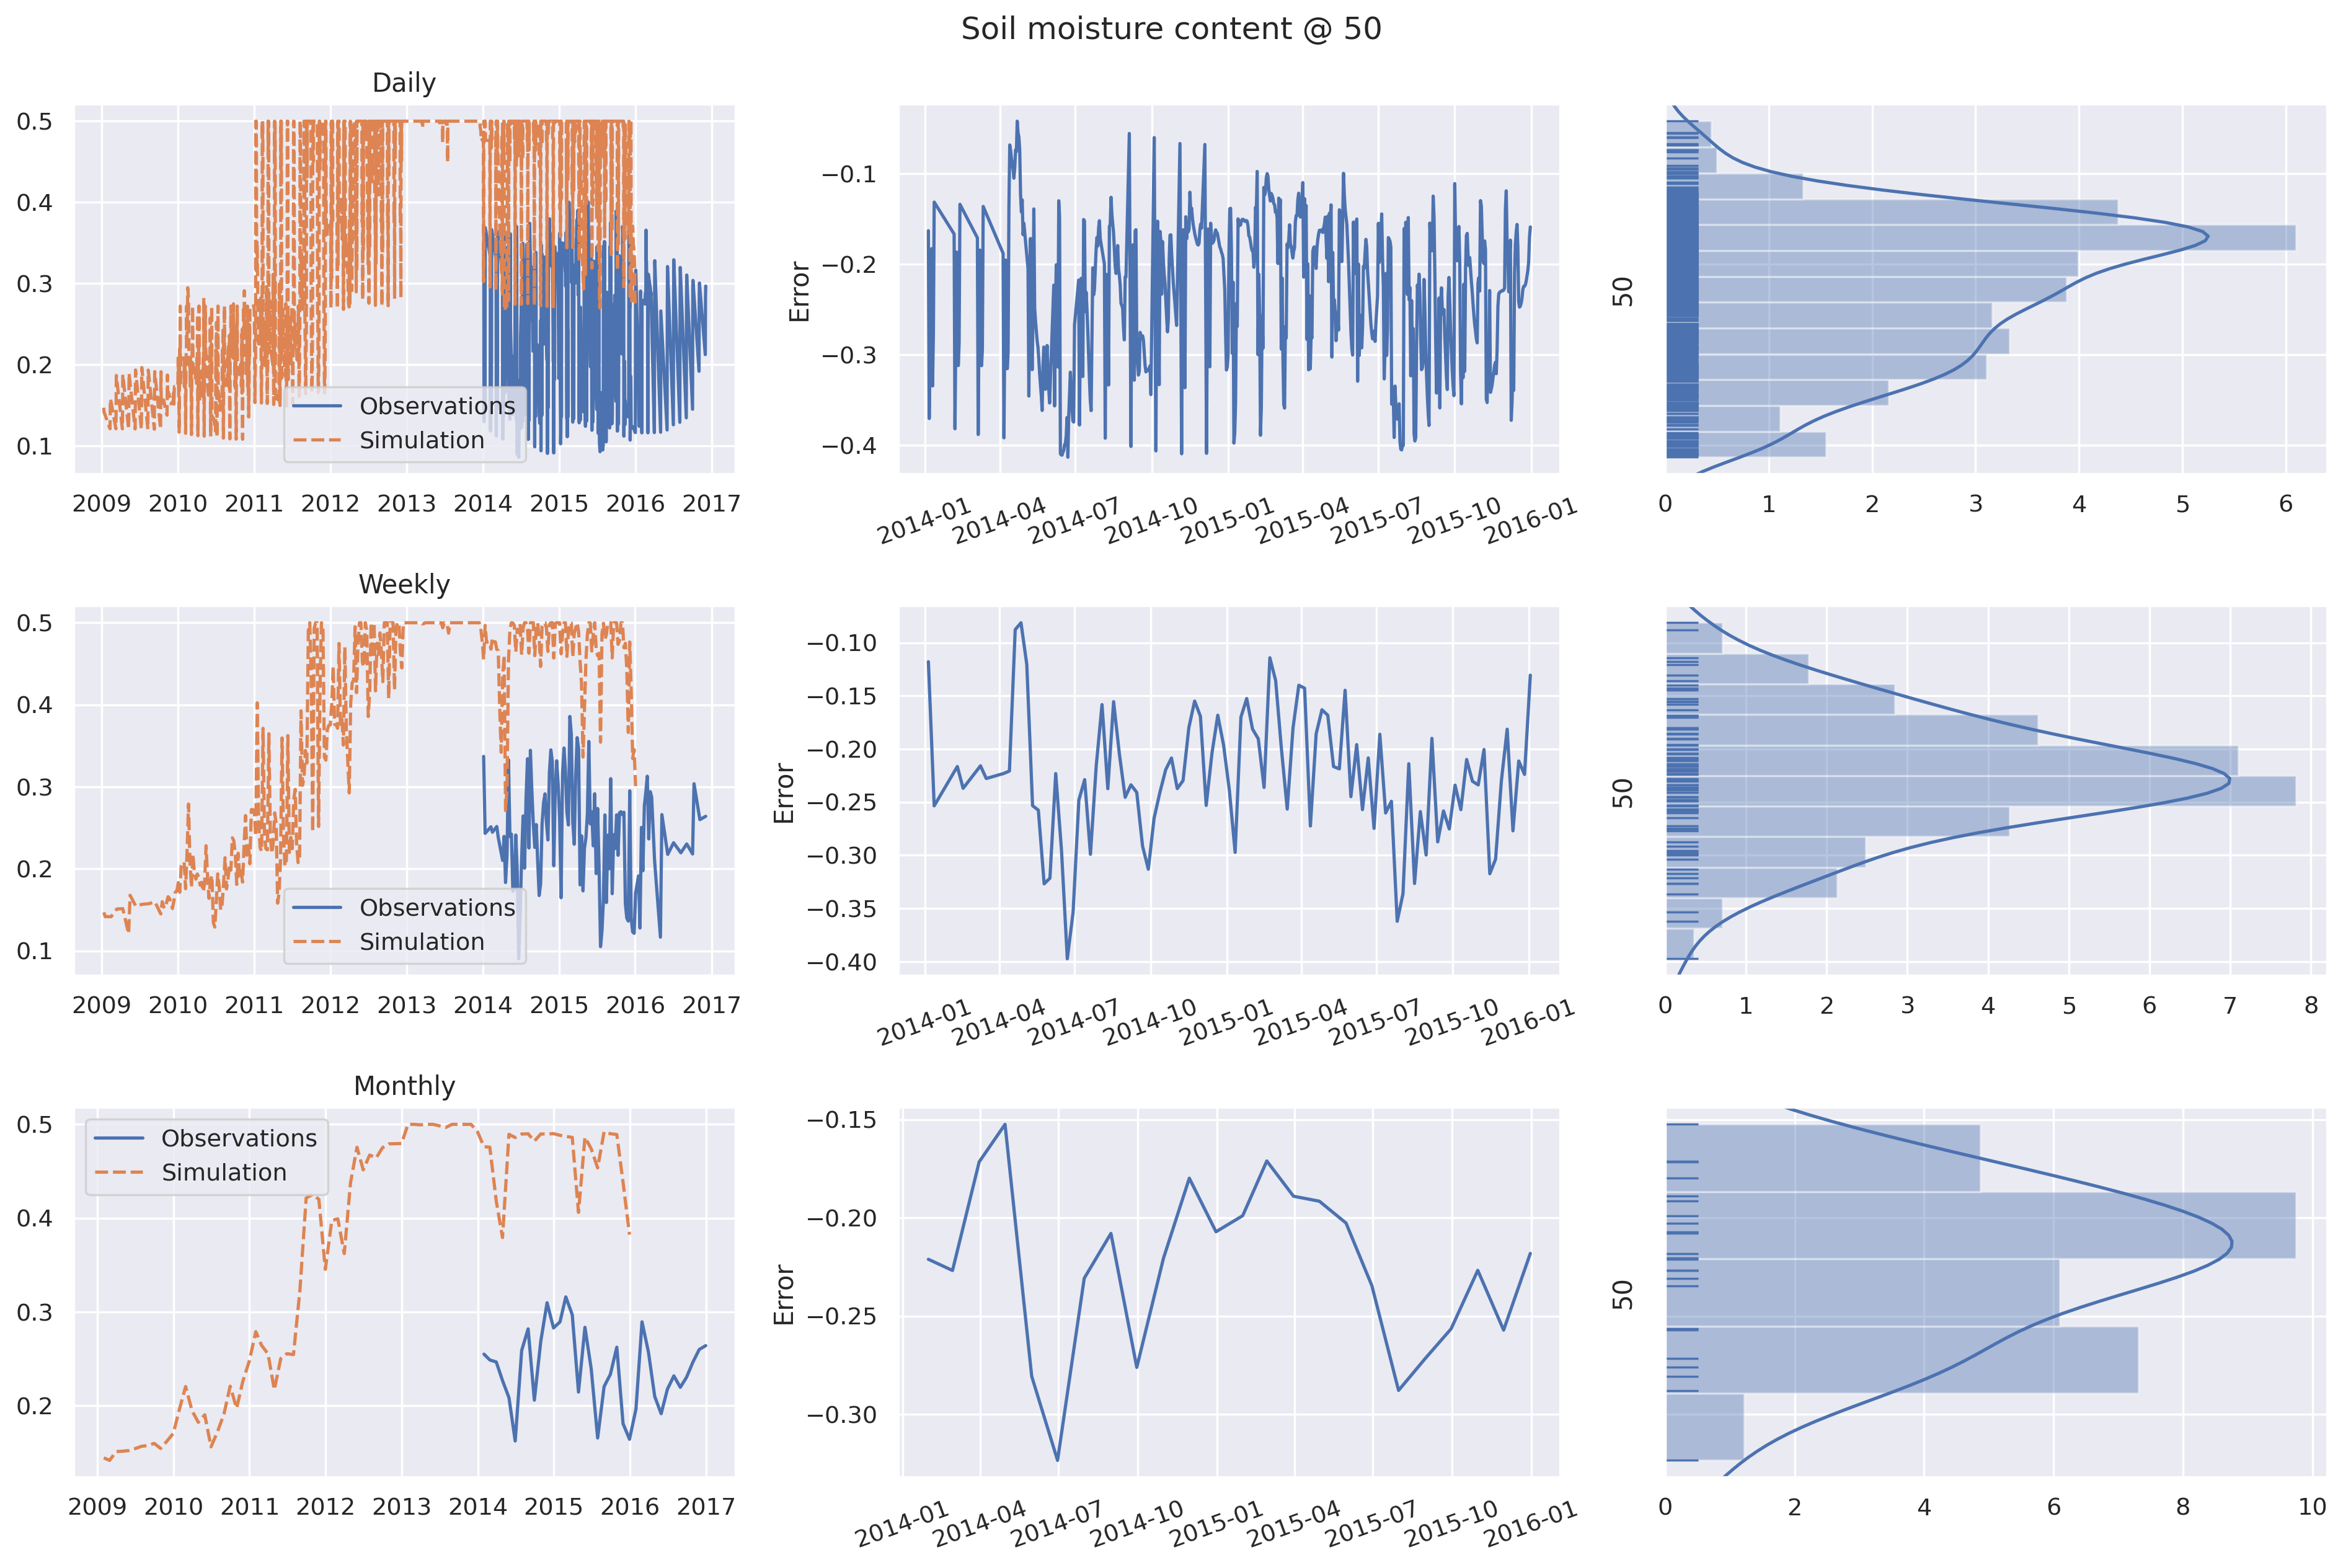

In [5]:
print(f"Model loss with all zeros is {model.loss(np.full(10, 0.0))}")
compare(model.obs[50], model.theta[50], name='Soil moisture content @ 50')
plt.show()

In [6]:
optimizer = ng.optimizers.PSO(parametrization=10, budget=8, num_workers=2)

with futures.ProcessPoolExecutor(max_workers=optimizer.num_workers) as executor:
    recommendation = optimizer.minimize(model.loss, executor=executor, batch_mode=False)

/home/max/.local/share/virtualenvs/MHPC-project-WaUKRq_w/lib/python3.8/site-packages/nevergrad/optimization/optimizerlib.py:636: InefficientSettingsWarning: PSO is inefficient with budget < 60
  warnings.warn("PSO is inefficient with budget < 60", base.InefficientSettingsWarning)


Recommended value is [-1.38731727  1.21039295  0.64210235 -0.92435865 -0.03792669  1.10301862
  1.81048078  0.62809395  0.56784619  0.03209957]
Loss is 0.22611475104738737


Recommended value is [-1.38731727  1.21039295  0.64210235 -0.92435865 -0.03792669  1.10301862
  1.81048078  0.62809395  0.56784619  0.03209957]
After optimization loss is 0.22611475104738737


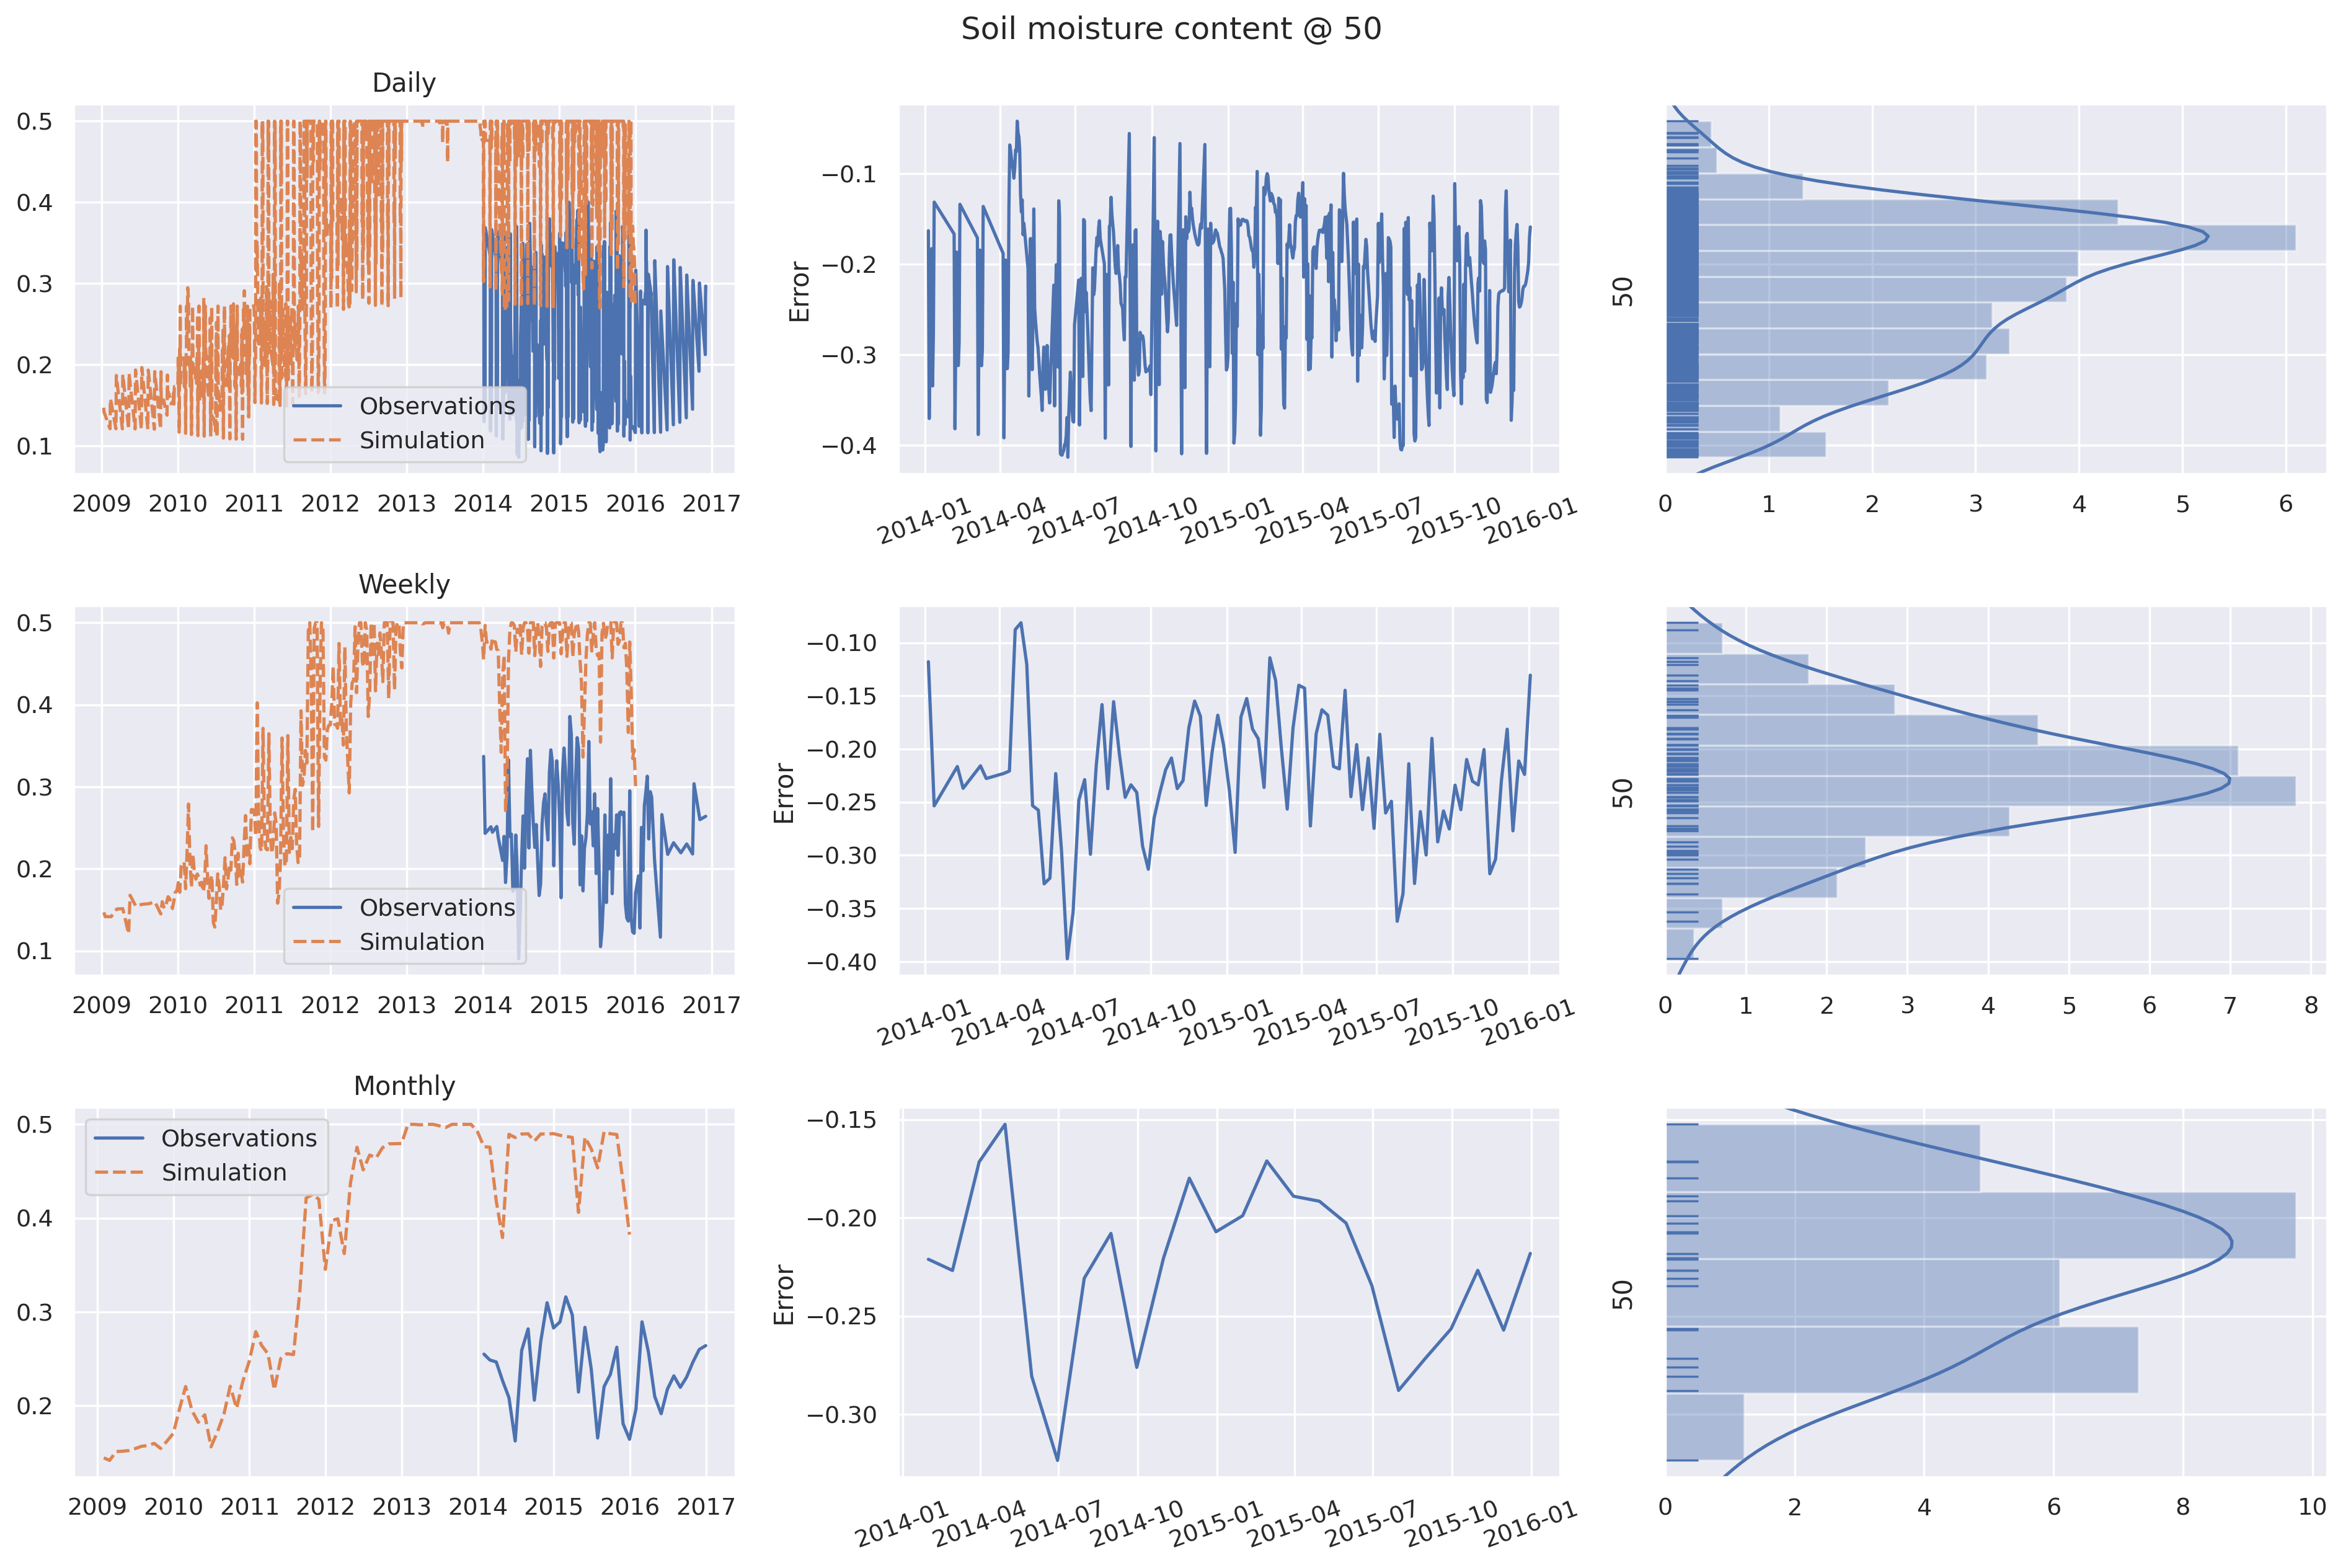

In [8]:
model.loss(recommendation.value)
print(f"Recommended value is {recommendation.value}")
print(f"After optimization loss is {recommendation.loss}")   
compare(model.obs[50], model.theta[50], name='Soil moisture content @ 50')
plt.show()